In [148]:
import astropy.units as u

from fleck import generate_spots
from fleck import Star

import numpy as np

from altaipony.altai import aflare
import matplotlib.pyplot as plt

from altaipony.utils import generate_random_power_law_distribution

import pytest
from flares import wrapped_aflare

# minimum todo

- ✓ test `create_flare_light_curve`
- test `flare_contrast`
- ✓ flares close to 1 in phase should wrap around `create_input_light_curve` 
- ✓ test `wrap_aflare`

# upgrade todo

- expand ed into FWHM and a in `create_input_light_curve`



# exploration
   
- fix the longitude of dominant spot

In [168]:
def create_flare_light_curve(time, emin, emax, alpha, beta):
    """Generate a flare light curve using the flare
    model from Davenport(2014) and power law disributed
    flare energies.
    
    Parameters:
    -----------
    time : np.array
        time series
    emin : float
        minimum energy that the spot can produce 
        OR detection limit, in ED space
    emax : float
        maximum energy that the
        spot can produce, in ED space
    alpha : float
        FFD power law exponent, in ED space
    beta : float
        FFD power law offset, in ED space
        
    Return:
    --------
    np.array with the same length as time, that is a light curve
    that contains a number of flares specified by the input parameters
    in relative flux units
    """
    # generate power law distributed flare energies
    EDs = generate_random_power_law_distribution(emin, emax, alpha+1, beta)
    
    # generate start times of flare randomly
    tstart = (np.random.rand(len(EDs)) * (time[-1] - time[0])) + time[0]
    
    # generate each flare and sum up the flux. 
    # Add 1 as baseline, because the amplitude is given in relative units
    lc = (np.array([wrapped_aflare(time, tstart[i], .02, ed)[1] for i, ed in enumerate(EDs)]).sum(axis=0) + 1.)
    
    return lc



In [ ]:
# unwrap EDs into a and fwhm


In [172]:
def test_create_flare_light_curve():
    """This basically call two functions that are
    individually tested elsewhere: wrapped_aflare and 
    generate_random_power_law_distribution.
    """
    # set up time array
    time = np.linspace(0,1,1000)

    # create a flare lc
    lc = create_flare_light_curve(time, 0.1, 1000, -2, 2)
    
    # just make sure the shape of the light curve is preserved
    assert lc.shape == time.shape


In [173]:
lc.shape, time.shape

((1000,), (1000,))

In [174]:
test_create_flare_light_curve()

(1000,) (1000,)


In [3]:
def flare_contrast(t, n_spots, emin, emax, alpha, beta, n_inclinations):
    """Creates a set of flaring light curves.
    
    Parameters:
    -----------
    t : np.array
        array of phases in [0,1]
    n_spots : int
        number of flaring spots, i.e. active regions
    emin : list of floats
        len(emin)=n_spots
        minimum energy that the spot can produce 
        OR detection limit, in ED space
    emax : list of floats
        len(emax)=n_spots
        maximum energy that the
        spot can produce, in ED space
    alpha : list of floats
        len(alpha)=n_spots
        FFD power law exponent, in ED space
    beta : list of floats
        len(beta)=n_spots
        FFD power law offset, in ED space
    n_inclinations : int
        i.e., number of stars
    
    Return:
    --------
    np.ndarray with dimensions (len(t), n_spots, n_inclinations),
    i.e., a matrix of n_spots x n_inclination flare light curves
    of length len(t), each with quiescent flux=1
    """
    
    # expand the time series to the number of spots
    t2d = np.repeat(np.array([t]), repeats=n_spots, axis=0)
                    
    # expand the time series to the number of stars
    t3d = np.repeat(t2d.T[:,:,np.newaxis], repeats=n_inclinations, axis=2)
    
    # define a nested function to wrap the 3d array
    def apply_per_spot(t3d, emin, emax, alpha, beta):
        # create a flare light curve for each star
        # with the same flaring region parameters
        return np.apply_along_axis(create_input_light_curve, 0,
                                   t3d, emin, emax, alpha, beta)
    
    # apply function above for each spot
    return np.array([apply_per_spot(t3d[:,i,:], emin[i], emax[i],
                                    alpha[i]+1, beta[i]) for i in range(t3d.shape[1])])

In [4]:
# Here, generate all LCs
t = np.arange(0, 2 * np.pi, 2 * np.pi/600) 
n_inclinations = 1000
n_spots = 1
alpha = [-1.6]*n_spots
beta = [200]*n_spots
emin = [1]*n_spots
emax = [100]*n_spots

flares = flare_contrast(t, n_spots, emin, emax, alpha, beta, n_inclinations)

In [5]:
u_ld = [0.5079, 0.2239]

n_phases = 1
phases = t * u.rad

In [6]:
flares.shape

(1, 600, 1000)

In [33]:
# infer active region radius for each lc
spot_radius = np.array([0.01]*n_spots).reshape((n_spots,1))   # Rspot/Rstar , should be the same shape as nspotnincflare
min_latitude = 50  # deg
max_latitude = 60   # deg

# replace with generate_active_regions()
lons, lats, radii, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                n_inclinations=n_inclinations)



In [34]:
lons = np.linspace(100,160,1000).reshape((1,1000)) * u.deg

In [35]:
# should be (nspots, n_inclinations), (nspots, n_inclinations), (phases, nspots, n_inclinations) 
lons.shape, lats.shape, radii.shape, inc_stellar.shape

((1, 1000), (1, 1000), (1, 1000), (1000,))

In [36]:
flares.shape

f = np.transpose(flares, (1, 0, 2))

In [37]:
f.shape

(600, 1, 1000)

In [38]:
star = Star(spot_contrast=f, phases=phases, u_ld=u_ld, n_phases=1)

In [39]:
lcs = star.light_curve(lons, lats, radii, inc_stellar)

(600, 1, 1, 3, 3)


In [40]:
# should be (phases, n_inclinations)
lcs.shape

(600, 1000)

In [41]:
star.phases

<Quantity [0.        , 0.01047198, 0.02094395, 0.03141593, 0.0418879 ,
           0.05235988, 0.06283185, 0.07330383, 0.0837758 , 0.09424778,
           0.10471976, 0.11519173, 0.12566371, 0.13613568, 0.14660766,
           0.15707963, 0.16755161, 0.17802358, 0.18849556, 0.19896753,
           0.20943951, 0.21991149, 0.23038346, 0.24085544, 0.25132741,
           0.26179939, 0.27227136, 0.28274334, 0.29321531, 0.30368729,
           0.31415927, 0.32463124, 0.33510322, 0.34557519, 0.35604717,
           0.36651914, 0.37699112, 0.38746309, 0.39793507, 0.40840704,
           0.41887902, 0.429351  , 0.43982297, 0.45029495, 0.46076692,
           0.4712389 , 0.48171087, 0.49218285, 0.50265482, 0.5131268 ,
           0.52359878, 0.53407075, 0.54454273, 0.5550147 , 0.56548668,
           0.57595865, 0.58643063, 0.5969026 , 0.60737458, 0.61784656,
           0.62831853, 0.63879051, 0.64926248, 0.65973446, 0.67020643,
           0.68067841, 0.69115038, 0.70162236, 0.71209433, 0.72256631,
      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


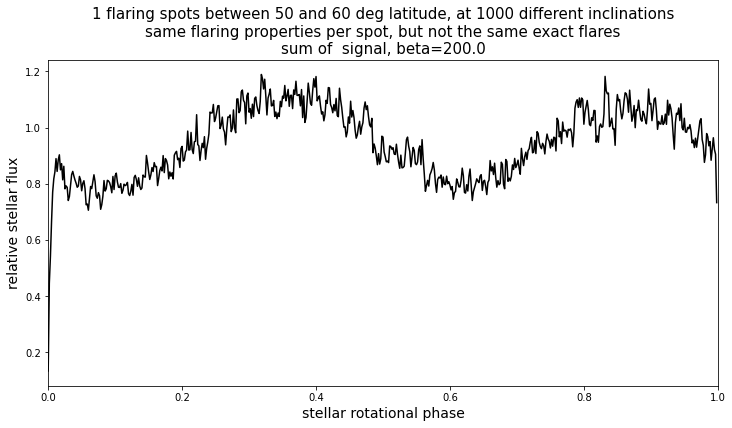

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(star.phases/2/np.pi, (lcs-1).sum(axis=1), c="k")
plt.xlim(0,1)
plt.xlabel("stellar rotational phase", fontsize=14)
plt.ylabel("relative stellar flux", fontsize=14)
plt.legend(fontsize=15, loc=1, frameon=False);
# plt.yscale("log")
plt.title(f"{n_spots} flaring spots between {min_latitude:2d} and {max_latitude:2d} deg latitude,"
          f" at {n_inclinations:2d} different inclinations\n"
          f"same flaring properties per spot, but not the same exact flares\n"
          f"sum of  signal, beta={beta[0]:.1f}", fontsize=15)
plt.savefig(f"plots/2021_12_20_{n_spots}_spots_distribution_{min_latitude:2d}_{max_latitude:2d}_"
            f"sum_{n_inclinations:2d}_{beta[0]:.1f}_3.png", dpi=300);